# Úkol č. 3 - Segmentace zákazníků e-shopu
**Deadline úkolu je uveden na [course pages](https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html).**

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu, která jsou v přiloženém souboru `eshop.csv`.

## Pokyny k vypracování

Ve všech bodech zadání uvažujte aktuální datum jako datum poslední transakce (19. 12. 2015), nikoliv dnešek. Tváříme se, že jde o aktuální data.

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

 ### Import použitých knižníc a funkcií

In [256]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import rrule
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
import collections, numpy
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score

 ### Pomocná funkcia na vyplotovanie 3D scatter grafov

In [243]:
plt.rc('figure',figsize = [15, 10])
plt.rc('axes', titlesize=20)  
plt.rc('axes', labelsize=18)

def plot(data, labels):
    ax = plt.figure().add_subplot(111, projection='3d')
    ax.scatter(data[:,0],data[:,1],data[:,2],c=labels, cmap='tab10', alpha=0.4)
    ax.set_xlabel("Recency")
    ax.set_ylabel("Frequency")
    ax.set_zlabel("Monetary")
    plt.show()

 # Vytvorenie RFM dataframu
Po prvotnom načítaní datasetu 'eshop.csv' som dáta zoradil podľa dátumu - nikde nie je napísané, že sú zoradené (aj keď to tak vyzerá), preto som to pre istotu urobil.. better be safe than sorry :)
- **R**ecency je vypočítaná ako posledný záznam každého unikátneho zákazníka (podľa Customer ID) - .drop_duplicates s parametrom keep='last' nechá len posledný záznam nákupu zákazníka - df je zoradený podľa dátumu, tým pádom si môžem byť istý, že tento záznam je posledný.. počet dní od dátumu Date v zázname je vypočítaný pomocou timedelta v datetime knižnici
- **F**requency je vypočítaná ako .value_counts podľa Customer ID - počet záznamov/nákupov zákazníka
- **M**onetary je vypočítané ako sum() nákupov zákazníka - .groupby podľa Customer ID

In [177]:
df = pd.read_csv('eshop.csv')
# Sort, just to be sure
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date')

# Recency
rfm_df = df[['Customer ID', 'Date']].drop_duplicates('Customer ID', keep='last')\
            .copy()\
            .set_index('Customer ID')\
            .rename(columns={'Date': 'Recency'})
rfm_df['Recency'] = rfm_df['Recency'].apply(lambda x: (datetime(2015,12,19) - x).days)

# Frequency
rfm_df = pd.merge(rfm_df, pd.DataFrame(df['Customer ID']
                                .value_counts())
                                .rename(columns={'Customer ID': 'Frequency'})
                                .rename_axis('Customer ID'),
                  on='Customer ID',
                  how='inner')

# Monetary
rfm_df = pd.merge(rfm_df, df.groupby('Customer ID').sum(), on='Customer ID', how='inner').rename(columns={'Subtotal': 'Monetary'})

In [231]:
rfm_df.tail()

,Recency,Frequency,Monetary
Customer ID,,,
15356,1,1,31.87
15357,1,1,6.10
15358,1,1,153.23
15359,0,1,19.15
15360,0,1,139.10


# Vytvorenie bonusového RFM dataframu
- **R**ecency je vypočítaná ako posledný záznam každého unikátneho zákazníka (podľa Customer ID) - .drop_duplicates s parametrom keep='last' nechá len posledný záznam nákupu zákazníka - df je zoradený podľa dátumu, tým pádom si môžem byť istý, že tento záznam je posledný.. narozdiel od základného zadania je hodnota počet mesiacov od posledného nákupu - vypočítané pomocou rrule knižnice
- **F**requency je vypočítaná ako .value_counts podľa Customer ID - počet záznamov/nákupov zákazníka za posledných 12 mesiacov (19.12.2014 - 19.12.2015)
- **M**onetary je najvyššia hodnota nákupu zákazníka.. tú som docielil sortom dataframu a vyhodením (ne)posledných unikátnych záznamov podľa Customer ID

In [179]:
# Recency (max(1, number_of_months_from_the_last_order))
bonus_rfm_df = df[['Customer ID', 'Date']].drop_duplicates('Customer ID', keep='last')\
                  .copy()\
                  .set_index('Customer ID')\
                  .rename(columns={'Date': 'Recency'})
bonus_rfm_df['Recency'] = bonus_rfm_df['Recency'].apply(lambda x: max(len(list(rrule.rrule(rrule.MONTHLY, dtstart=x, until=datetime(2015,12,19))))-1, 1))

# Frequency (max(1, number_of_orders_in_the_last_12_months))
bonus_rfm_df = pd.merge(bonus_rfm_df, pd.DataFrame(df.loc[df['Date'] >= datetime(2014,12,19)]['Customer ID']
                                .value_counts())
                                .rename(columns={'Customer ID': 'Frequency'})
                                .rename_axis('Customer ID'),
                  on='Customer ID',
                  how='outer').fillna(1.0)

# Monetary (max(customer_order_subtotal))
bonus_rfm_df = pd.merge(bonus_rfm_df, df[['Customer ID', 'Subtotal']]
                            .sort_values('Subtotal')
                            .drop_duplicates('Customer ID', keep='last')
                            .copy()
                            .set_index('Customer ID')
                            .rename(columns={'Subtotal': 'Monetary'}), on='Customer ID', how='inner')

In [230]:
bonus_rfm_df.tail()

,Recency,Frequency,Monetary
Customer ID,,,
15356,1,1.0,31.87
15357,1,1.0,6.10
15358,1,1.0,153.23
15359,1,1.0,19.15
15360,1,1.0,139.10


# Zobrazenie clusterov
Ako defaultnú hodnotu k som zvolil 3.. Je vidno, najmä na bonusovom RFM dataframe, že clustery nie sú "spravodlivo" rozdelené, kvôli veľkým rozdielom medzi dimenziami (napr. hodnotami ceny tovaru a počtu mesiacov od posledného nákupu). Tomuto problému pomôže práve normalizovanie dát - preškálovanie  na hodnoty \[0,1\]

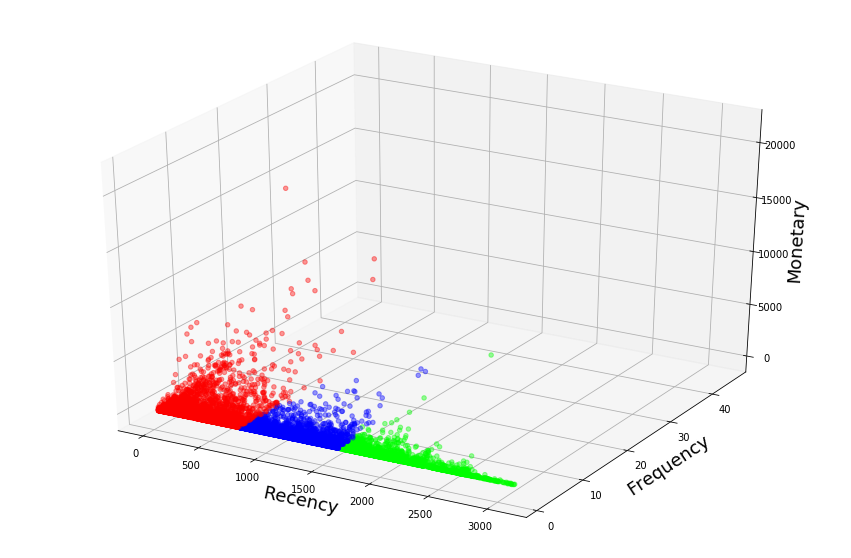

In [223]:
rfm_data = np.array(rfm_df)

kmeans = KMeans(n_clusters=3, random_state=0).fit(rfm_data)

plot(rfm_data, kmeans.labels_)

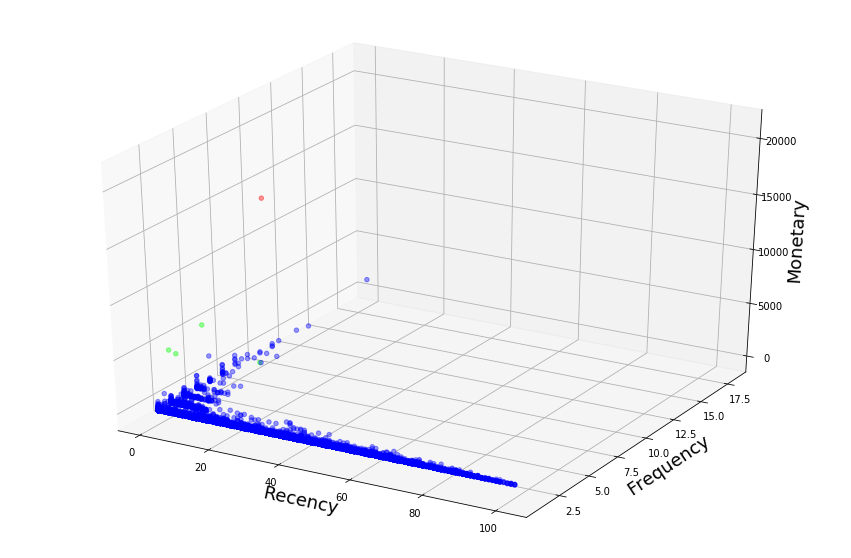

In [224]:
bonus_rfm_data = np.array(bonus_rfm_df)

kmeans = KMeans(n_clusters=3, random_state=0).fit(bonus_rfm_data)

plot(bonus_rfm_data, kmeans.labels_)

# Preškálovanie dát
Dáta som preškáloval pomocou MinMaxScaler funkcie.
Na vyplotovaných grafov je vidieť, že preškálovanie pomohlo - dáta sú viac pri sebe - pomer ich vzdialeností je rovnaký. Najväčší rozdiel je znovu vidieť na bonusových dátach, kde zákazníci, ktorí kupujú častejšie a drahší tovar, sú spolu v jednom clusteri, oddelení od ostatných

In [227]:
scaler = MinMaxScaler()
rfm_data_scaled = scaler.fit_transform(rfm_df)
bonus_rfm_data_scaled = scaler.fit_transform(bonus_rfm_df)

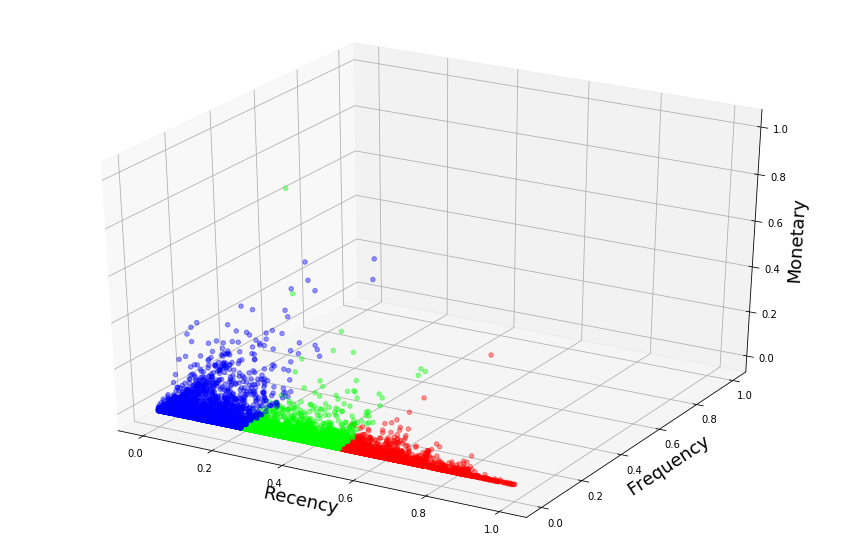

In [225]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(rfm_data_scaled)

plot(rfm_data_scaled, kmeans.labels_)

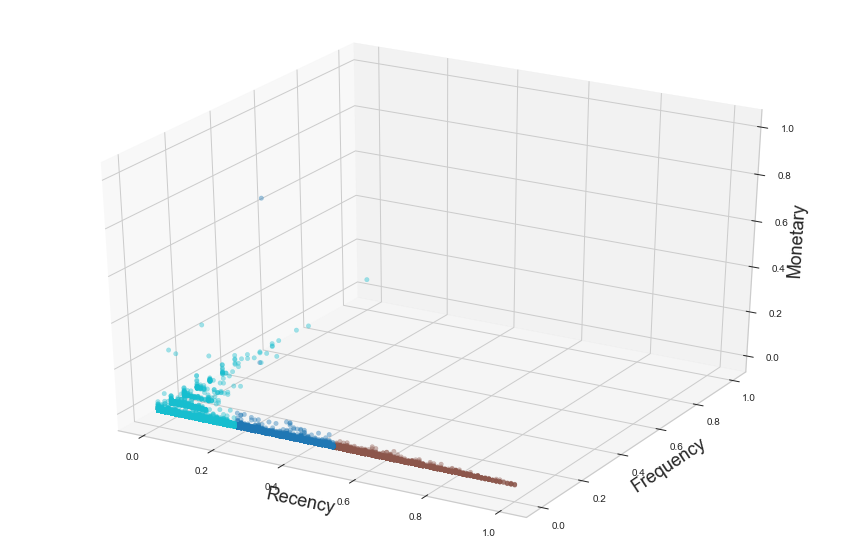

In [304]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(bonus_rfm_data_scaled)

plot(bonus_rfm_data_scaled, kmeans.labels_)

# Nájdenie optimálneho 'k'
Po normalizácii dát je treba nájsť optimálne k - v tom som si pomohol 2 metódami - nájdením tzv. elbow podľa distortion a silhouette skóre, elbow silhouette skóre úvahu som podporil aj vykreslením silhouette grafmi na lepšiu vizualizáciu problému.
Funkcie na získavanie skóre a vizualizácie grafov som využil pre základné a aj bonusové RFM zadanie

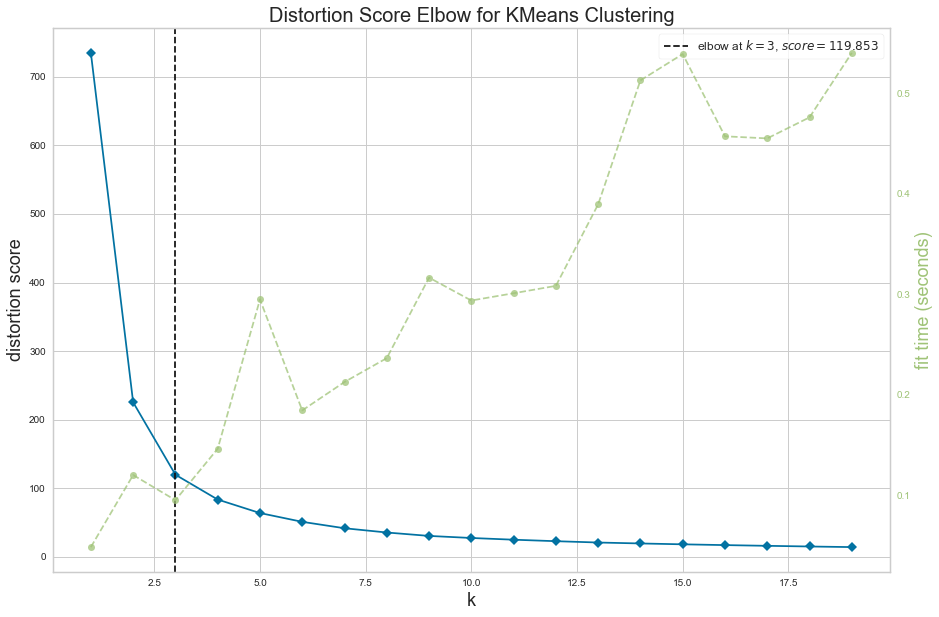

In [265]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(rfm_data_scaled)
visualizer.show()

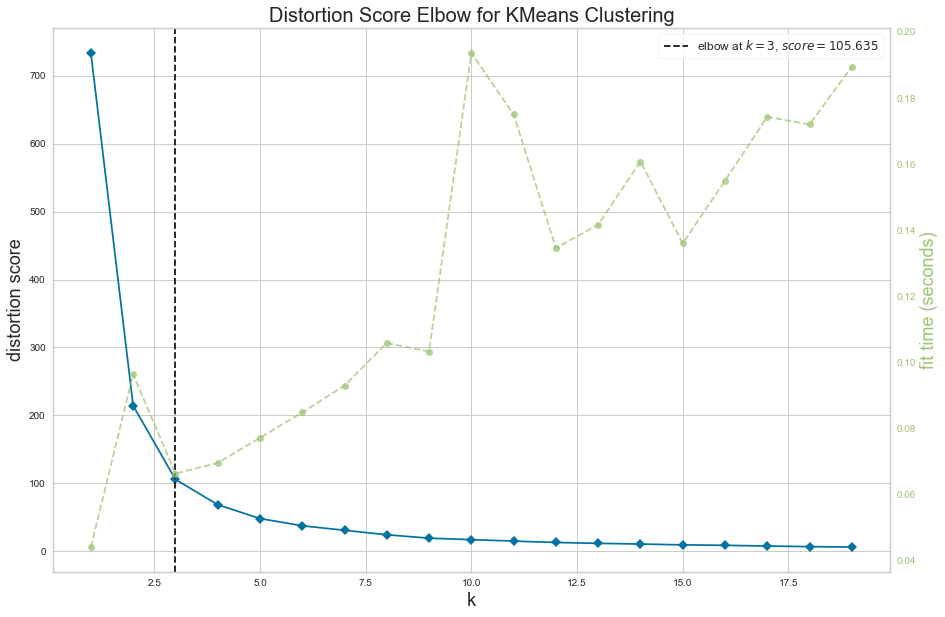

In [267]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(bonus_rfm_data_scaled)
visualizer.show()

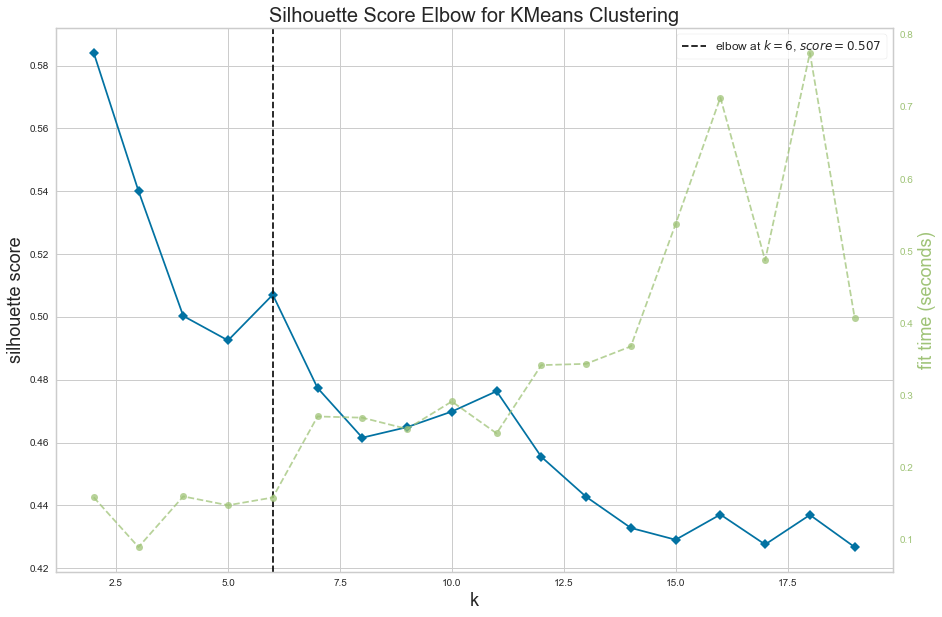

In [310]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20), metric='silhouette')

visualizer.fit(rfm_data_scaled)
visualizer.show()

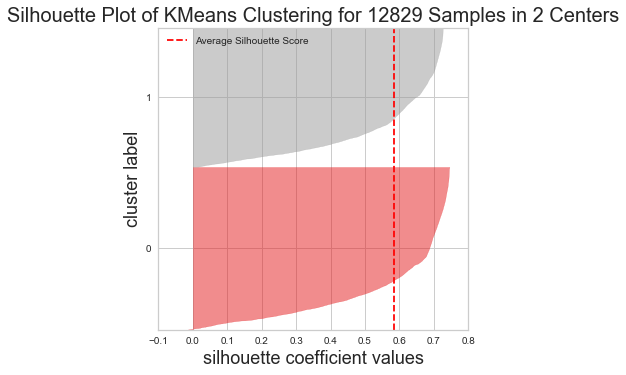

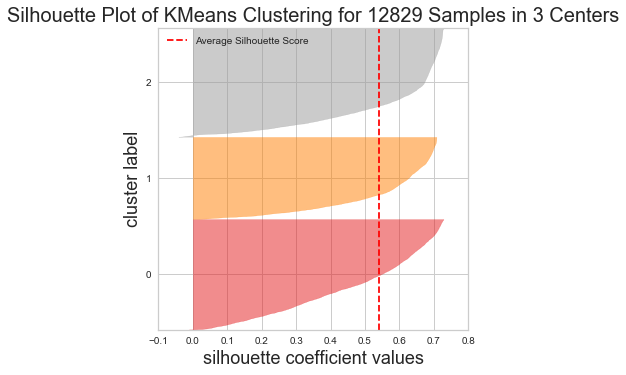

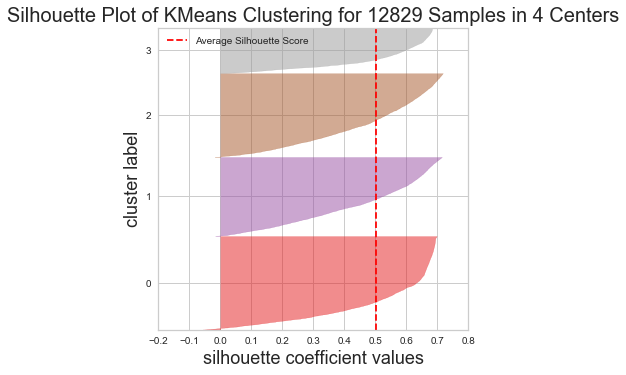

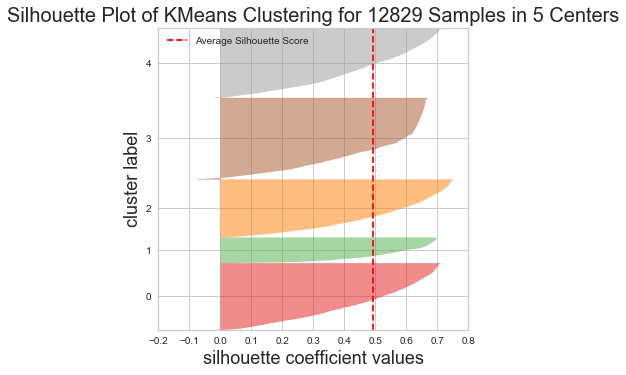

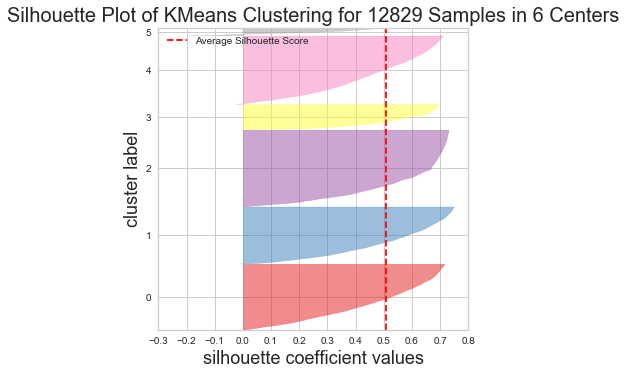

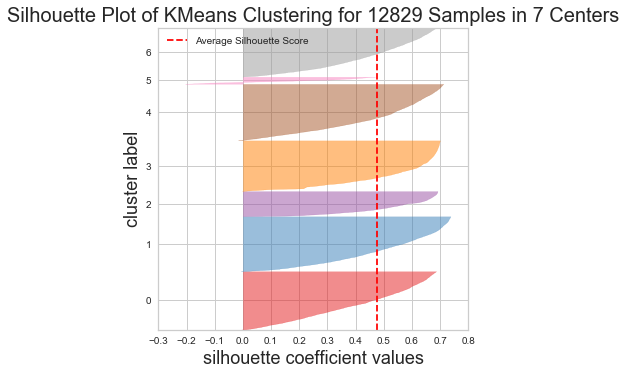

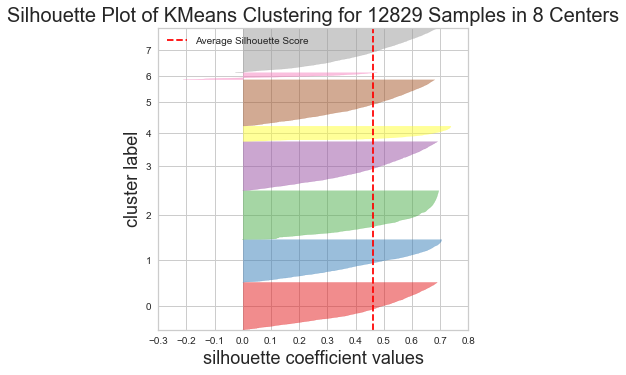

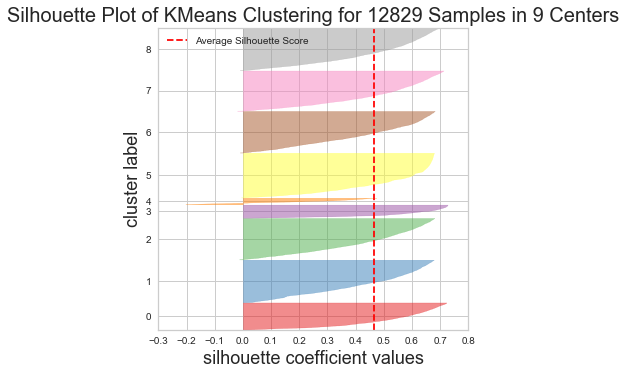

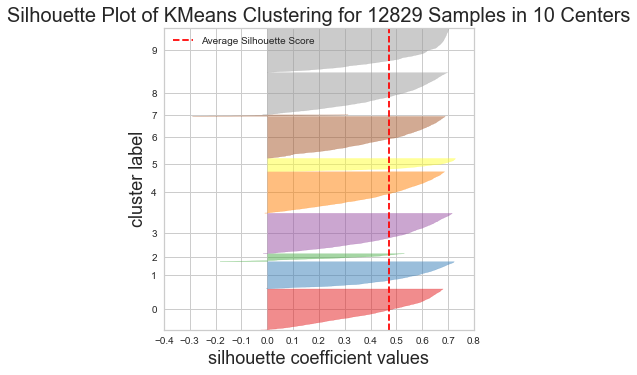

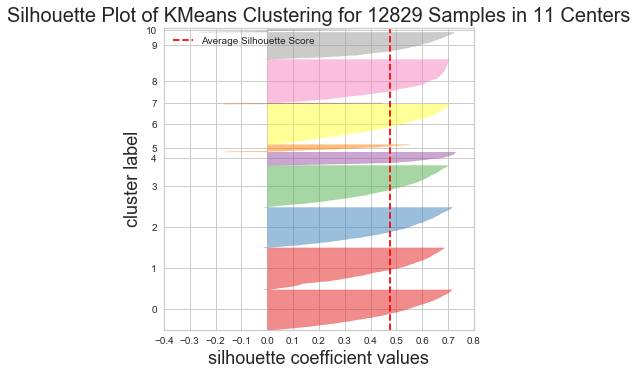

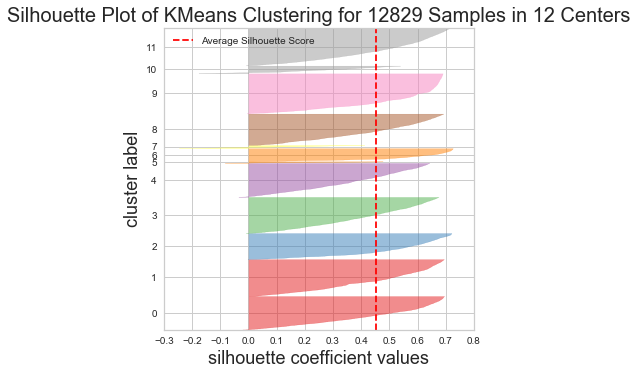

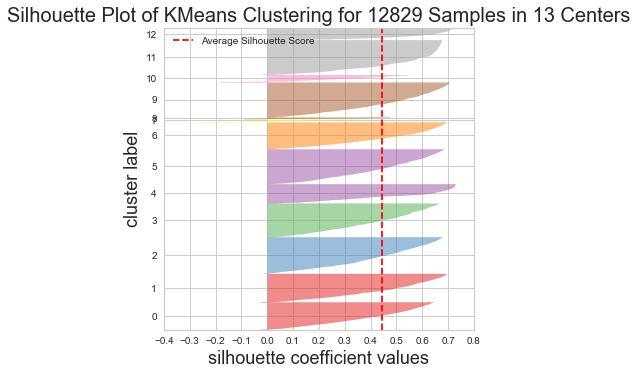

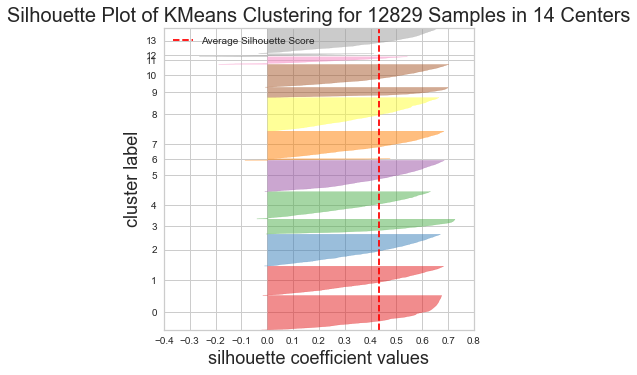

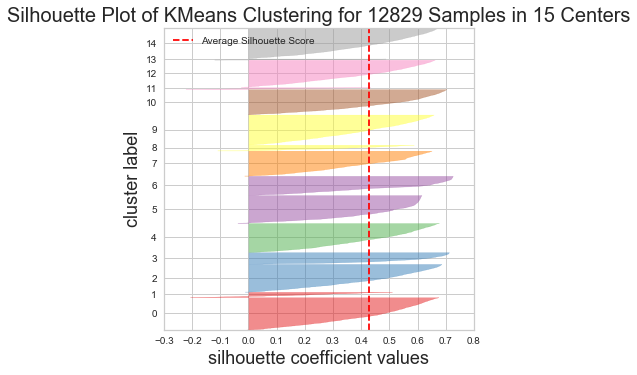

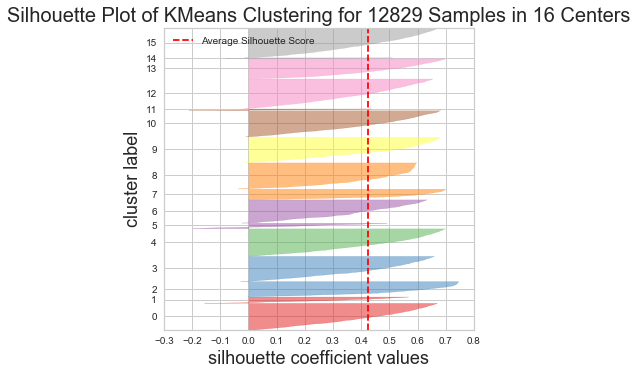

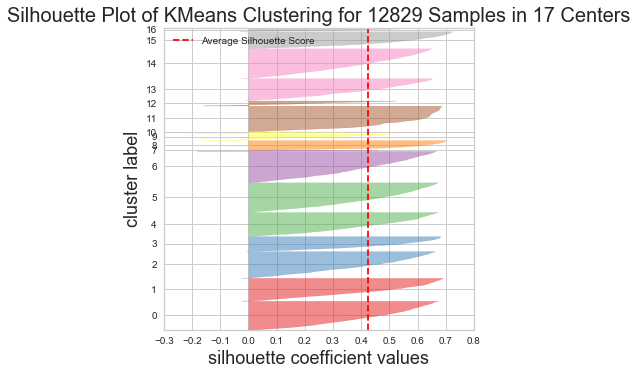

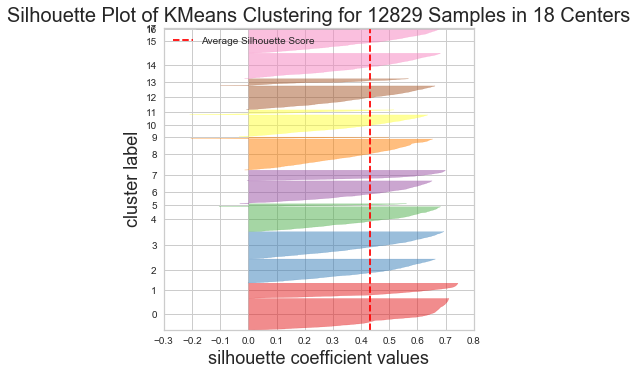

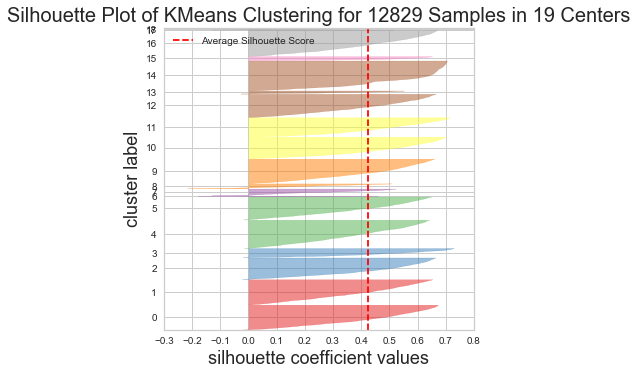

In [303]:
for k in range(2, 20):
    model = KMeans(k)
    visualizer = SilhouetteVisualizer(model, size=(400, 400))

    visualizer.fit(rfm_data_scaled)
    visualizer.poof()

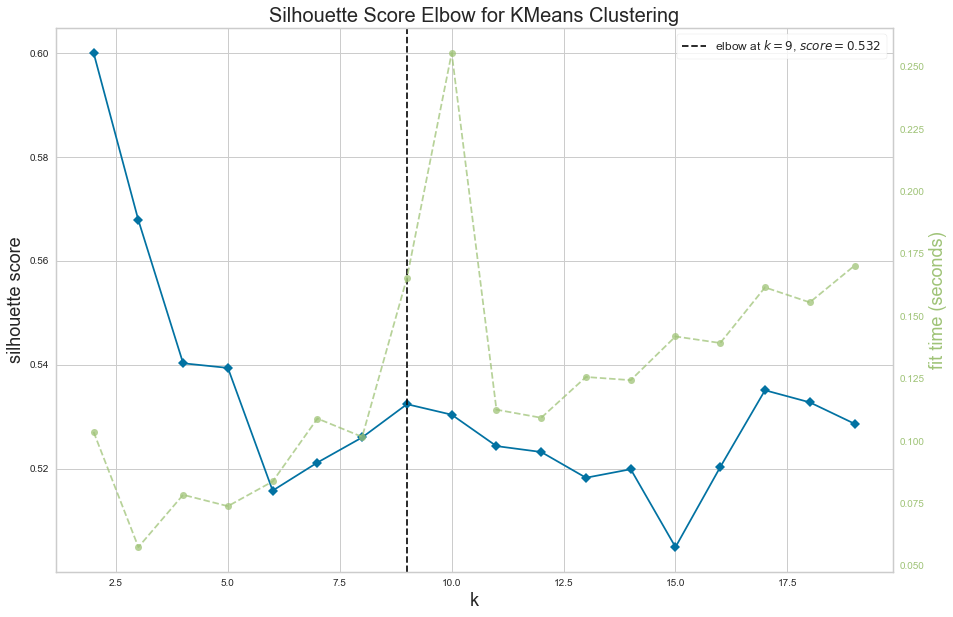

In [311]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20), metric='silhouette')

visualizer.fit(bonus_rfm_data_scaled)
visualizer.show()

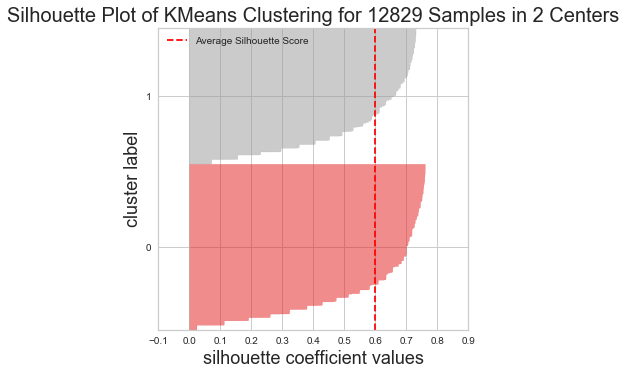

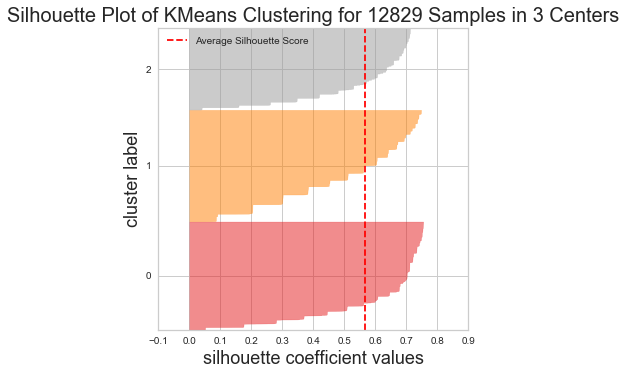

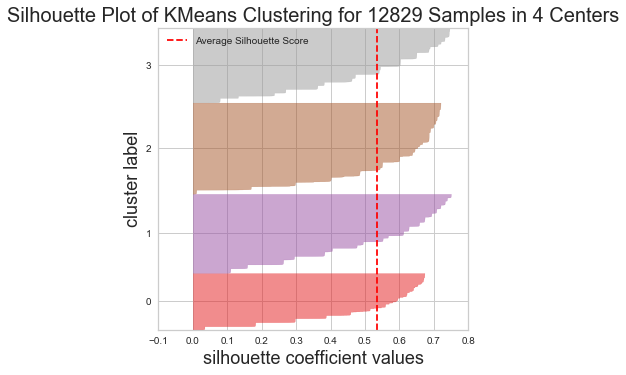

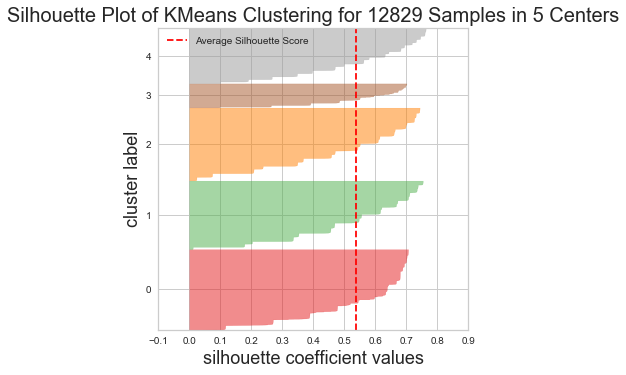

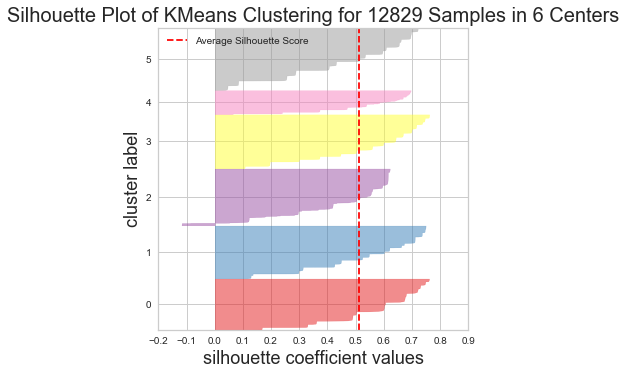

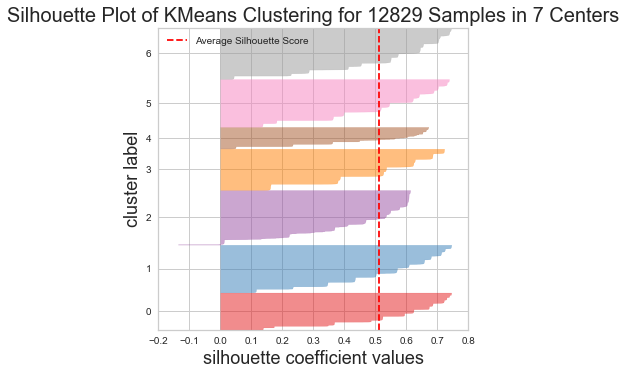

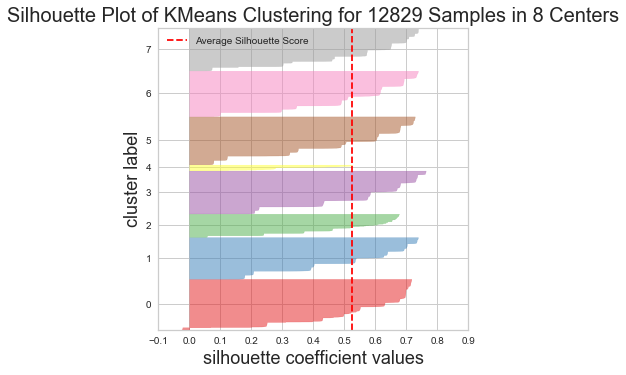

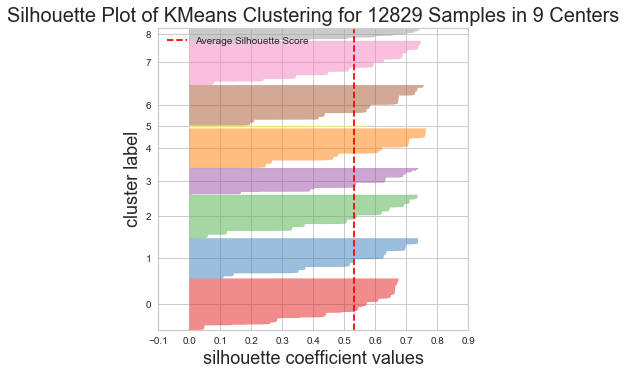

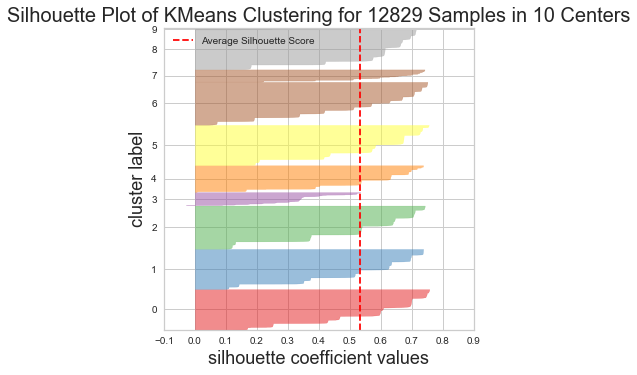

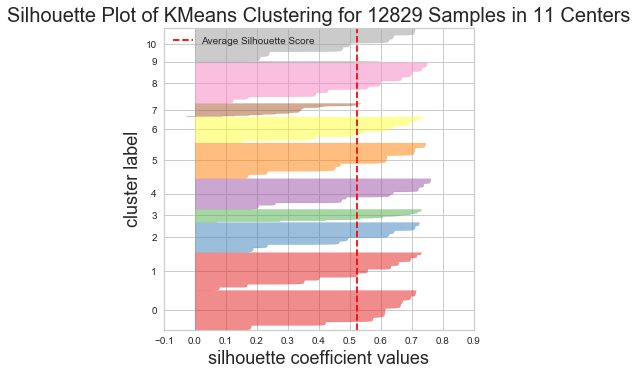

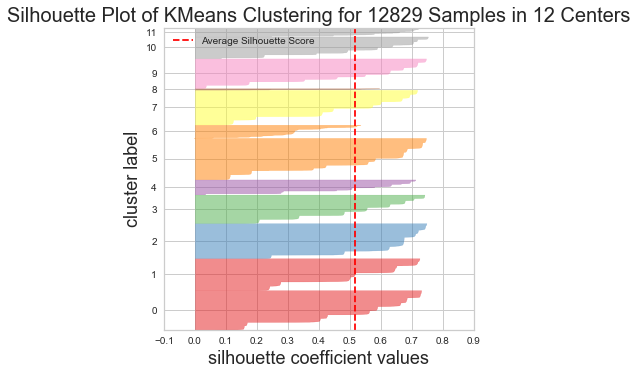

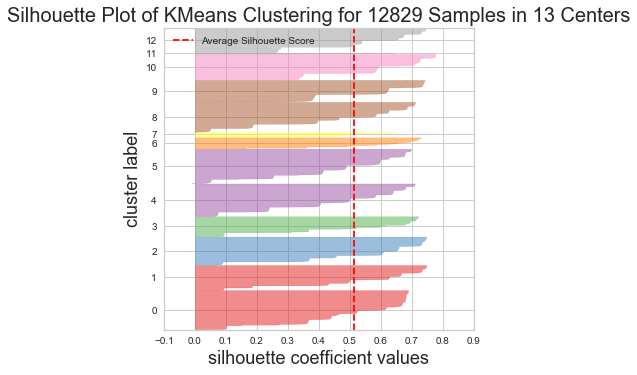

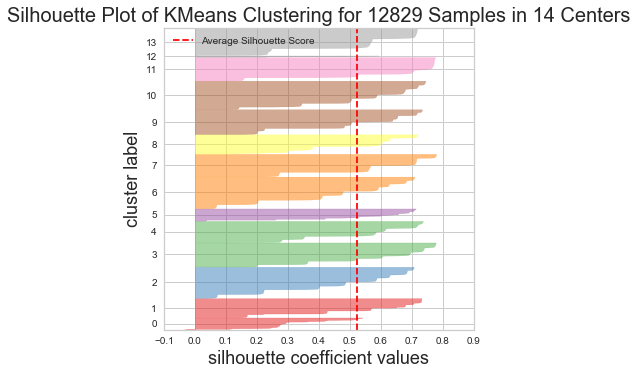

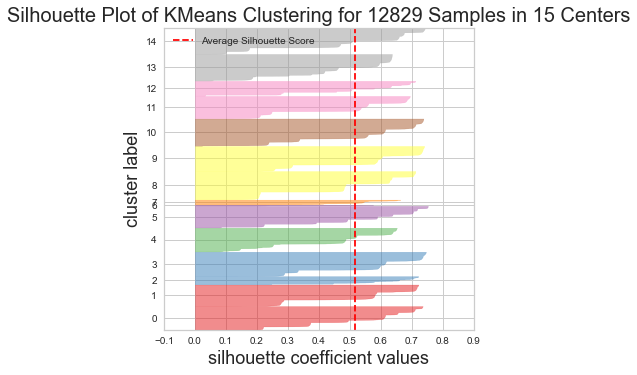

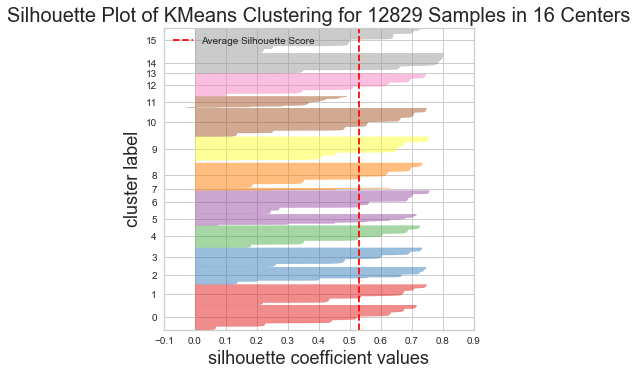

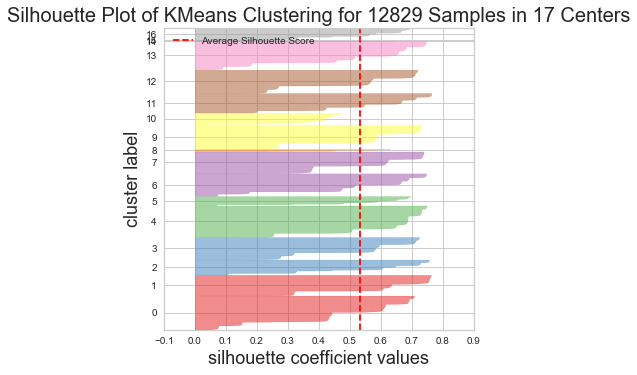

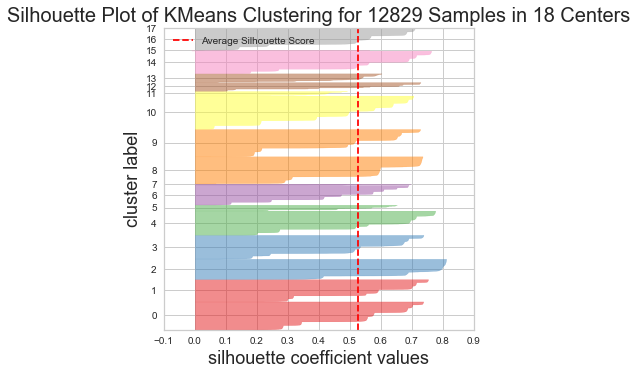

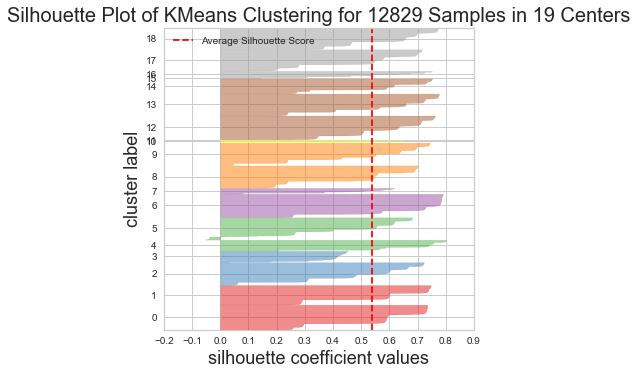

In [300]:
for k in range(2, 20):
    model = KMeans(k)
    visualizer = SilhouetteVisualizer(model, size=(400, 400))

    visualizer.fit(bonus_rfm_data_scaled)
    visualizer.poof()

# Výsledné clustery zákazníkov
K nájdeniu ideálneho 'k' som si pomohol funkciami a grafmi vyššie, pri finálnom rozhodovaní som bral v potaz ako výsledky grafov vyššie, tak aj vzhľad výsledných clusterov podľa môjho subjektívneho názoru.<br>
- Pre základné zadanie som sa rozhodol pre k=6, čo je výsledok silhouette score "lakťa" - silhouette vizualizácie pri 6 clusteroch sa taktiež na seba pomerne dobre podobajú.
 - Superstar zákazníci sú zobrazení ako tyrkysoví
- Pre bonusové zadanie RFM som sa rozhodol taktiež pre k=6, pretože siluety sa pri k=6 podobajú viac ako pri 8, a výsledný cluster lepšie zhlukuje zákazníkov - žltí zákazníci nakupujú najdrahší tovar, najviac frekventovane a v blízkej dobe

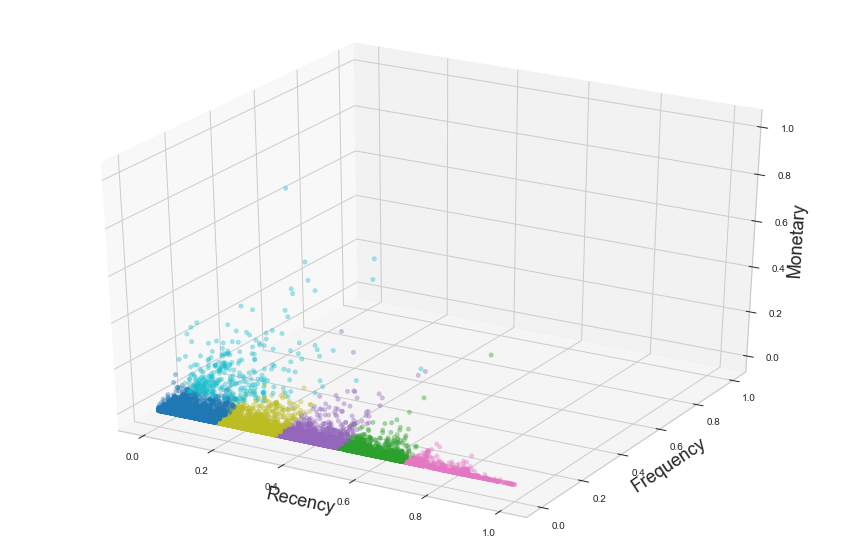

In [324]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(rfm_data_scaled)

plot(rfm_data_scaled, kmeans.labels_)

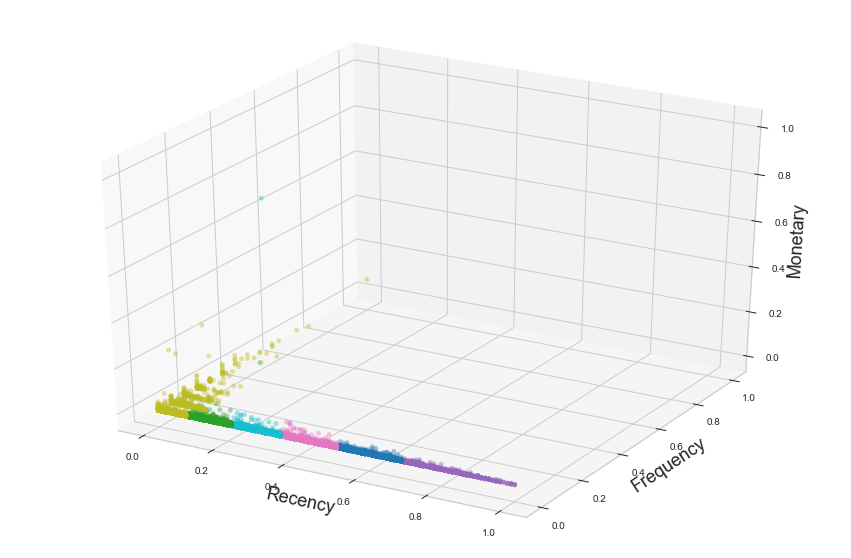

In [325]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(bonus_rfm_data_scaled)

plot(bonus_rfm_data_scaled, kmeans.labels_)